# Classification using Sentence-BERT and kNN

This notebook demonstrates text classification using:
1.  **Feature Engineering**: Sentence-BERT (SBERT) to generate semantically meaningful sentence embeddings.
2.  **Classification Algorithm**: K-Nearest Neighbors (kNN) with Cosine Similarity.

Target Label: `Label`
Content: `Cleaned_Content`

In [1]:
%pip install sentence-transformers

  Using cached tokenizers-0.22.2-cp39-abi3-win_amd64.whl.metadata (7.4 kB)
  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   -------------- ------------------------- 3.7/10.1 MB 17.8 MB/s eta 0:00:01
   ---------------------------- ----------- 7.3/10.1 MB 18.1 MB/s eta 0:00:01
   ---------------------------------------- 10.1/10.1 MB 17.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/536.7 kB ? eta -:--:--
   --------------------------------------- 536.7/536.7 kB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 2.9/2.9 MB 15.1 MB/s eta 0:00:00
Using cached tokenizers-0.22.2-cp39-abi3-win_amd64.whl (2.7 MB)
Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl (341 kB)
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   - -------------------------------------- 4.2/1

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure reproducible results
np.random.seed(42)

In [ ]:
# Load the dataset
file_path = '../cleaned_data.csv'
data = pd.read_csv(file_path)

# Drop rows with missing values
data = data.dropna(subset=['Label', 'Cleaned_Content'])

# Display the first few rows
data.head()

,Content,Paper Name,Label,Cleaned_Content
0,Insulin resistance is a condition characterize...,Brain insulin resistance mediated cognitive im...,Alzheimer's Disease,insulin resistance condition characterized att...
1,substrate 1 (IRS1)/PI3K/AKT and IGF-1 receptor...,Brain insulin resistance mediated cognitive im...,Alzheimer's Disease,substrate irs pi akt igf receptor igf irs pi p...
2,Prolactin is a pituitary anterior lobe hormone...,Hyperprolactinemia and Brain Health: Exploring...,Alzheimer's Disease,prolactin pituitary anterior lobe hormone play...
3,Lecanemab is an amyloid-targeted antibody indi...,Severe Persistent Urinary Retention Following ...,Alzheimer's Disease,lecanemab amyloid targeted antibody indicated ...
4,Glycoprotein 88 (GP88) is a secreted biomarker...,An Impedimetric Immunosensor for Progranulin D...,Alzheimer's Disease,glycoprotein gp secreted biomarker overexpress...


In [4]:
# Load pre-trained Sentence-BERT model
# 'all-MiniLM-L6-v2' is a small, fast model that performs very well for sentence embeddings.
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the text data
# This might take a little while depending on your hardware (CPU vs GPU)
print("Encoding sentences...")
embeddings = model.encode(data['Cleaned_Content'].tolist(), show_progress_bar=True)

print("Shape of embeddings:", embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

d:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Administrator\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding sentences...


Batches:   0%|          | 0/52 [00:00<?, ?it/s]

Shape of embeddings: (1641, 384)


In [5]:
# Split the data into training and testing sets
X = embeddings
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 1312
Testing set size: 329


In [6]:
# Initialize kNN Classifier with Cosine Similarity
# Metric='cosine' is crucial for high-dimensional embeddings.
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='cosine')

# Train the classifier
knn_classifier.fit(X_train, y_train)

print("kNN Model training completed.")

kNN Model training completed.


In [7]:
# Make predictions
y_pred = knn_classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6018

Classification Report:
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.69      0.59      0.64        71
Frontotemporal Dementia       0.65      0.60      0.62        77
     Lewy Body Dementia       0.51      0.72      0.59        60
    Parkinson's Disease       0.60      0.46      0.52        59
      Vascular Dementia       0.60      0.65      0.62        62

               accuracy                           0.60       329
              macro avg       0.61      0.60      0.60       329
           weighted avg       0.61      0.60      0.60       329



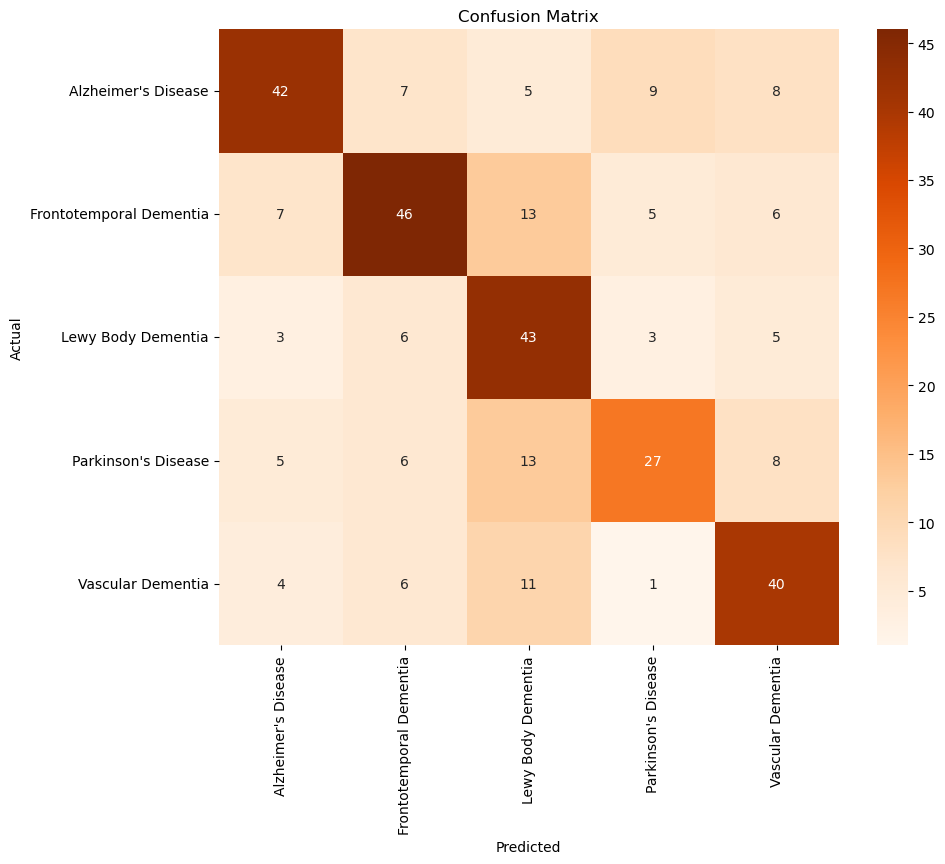

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()